In [ ]:
%%bash

pip install markdown tqdm textblob mpld3

In [159]:
%matplotlib inline

from azureml import Workspace, DataTypeIds

ws = Workspace()
news_frame = ws.datasets['all news.csv'].to_dataframe()
equity_frame = ws.datasets['msft_equity.csv'].to_dataframe()

In [160]:
news_frame

,title,author,timestamp,link,content
0,"Russia's RTS Climbs to Record on Oil; Lukoil, ...",Maria Ermakova,2006-11-30T16:04:58Z,http://www.bloomberg.com/news/2006-11-30/russi...,/n /n Stocks in...
1,"THQ, Other Game Makers' Shares Fall on Xbox Ou...",Michael White,2007-01-26T22:20:21Z,http://www.bloomberg.com/news/2007-01-26/thq-o...,/n /n Shares of...
2,"ValueClick May Have Several Suitors, Analyst Says",Eric Martin,2007-05-21T18:38:08Z,http://www.bloomberg.com/news/2007-05-21/value...,/n /n ValueClic...
3,Mission West Discloses Talks on $13.55-Share O...,Dan Hart,2007-07-14T18:33:45Z,http://www.bloomberg.com/news/2007-07-14/missi...,/n /n Mission W...
4,Game Console Sales Rose 20% in Dec.; Nintendo ...,Michael White,2008-01-18T00:42:06Z,http://www.bloomberg.com/news/2008-01-18/game-...,/n /n Video-gam...
5,"Google Drops as Net Misses, Microsoft Bids for...",Ari Levy,2008-02-01T21:25:39Z,http://www.bloomberg.com/news/2008-02-01/googl...,/n /n Google In...
6,Yahoo Investor Munder Prefers Microsoft to New...,Dina Bass,2008-02-14T21:22:25Z,http://www.bloomberg.com/news/2008-02-14/yahoo...,/n /n Yahoo! In...
7,France Telecom Software Venture Challenges Mic...,Rudy Ruitenberg,2008-02-20T13:24:27Z,http://www.bloomberg.com/news/2008-02-20/franc...,/n /n France Te...
8,Harvard Center to Lead Group to Aid Internet U...,Brian K. Sullivan,2008-02-28T17:59:54Z,http://www.bloomberg.com/news/2008-02-28/harva...,/n /n Harvard i...
9,Nintendo's Wii Holds Lead in U.S Video-Game Co...,Andy Fixmer,2008-03-14T01:14:51Z,http://www.bloomberg.com/news/2008-03-14/ninte...,/n /n Nintendo ...


In [161]:
news_frame['Date'] = news_frame['timestamp'].map(lambda x: str(x)[:10])

In [162]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ' '.join(self.fed) # merge with space


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

import sys

from multiprocessing import Pool
from time import time
from markdown import markdown
from tqdm import tqdm
import re


def cleaner_batch_perform(text):
    cleaner = Cleaner(text)
    cleaner.perform()
    return cleaner.cleared_text


class Cleaner:
    text = ""
    cleared_text = ""

    clearing_functions = []

    left_space_characters = {'(', '['}
    right_space_characters = {'.', ',', '!', '?', ':', ';', ')', ']'}  # what about ' and "
    space_characters = {'-', '+', '=', '&', '#'}

    times = {}

    def __init__(self, text: str):
        self.text = text

        self.clearing_functions = [
            self.strip_links,
            # self.strip_markdown,
            self.strip_html,
            self.strip_latex,
            self.strip_newlines,
            self.norm_spaces,
            self.norm_quotes,
        ]

    def perform(self):
        self.cleared_text = self.text

        for function in self.clearing_functions:
            # start = time()
            self.cleared_text = function()

            # if function.__name__ not in self.times:
            #     self.times[function.__name__] = 0
            #
            # self.times[function.__name__] += time() - start

    @staticmethod
    def batch_perform(texts):
        bar = tqdm(total=len(texts))
        cleared = []
        pool = Pool(processes=8, maxtasksperchild=1)
        for text in pool.imap(cleaner_batch_perform, texts, chunksize=100*1000):
            cleared.append(text)
            bar.update()

        return cleared

    def lower_case(self) -> str:
        return self.cleared_text.lower()

    def strip_html(self) -> str:
        return strip_tags(self.cleared_text)

    def strip_latex(self) -> str:
        stripped = re.sub("\$\$[^$$]+\$\$", '', self.cleared_text)  # $$...$$
        stripped = re.sub("\$[^$]+\$", '', stripped)  # $...$
        stripped = re.sub(r'\\begin\{(.*?)\}(.*?)\\end\{\1\}', '', stripped)  # \begin...\end
        self.cleared_text = re.sub('\[([^]]+)\]', '', stripped)  # [...]
        return self.cleared_text

    def strip_links(self) -> str:
        return re.sub(r'^https?:\/\/.*[\r\n]*', '', self.cleared_text, flags=re.MULTILINE)

    def strip_markdown(self) -> str:
        return markdown(self.cleared_text)

    def strip_newlines(self) -> str:
        return self.cleared_text.replace('\\n', '') \
            .replace('\\r', '') \
            .replace('\n', '') \
            .replace('\r', '') \
            .replace('\\', '')

    def norm_spaces(self) -> str:
        text = self.cleared_text

        for character in self.left_space_characters:
            text = text.replace(character, ' ' + character)

        for character in self.right_space_characters:
            text = text.replace(character, character + ' ')

        for character in self.space_characters:
            text = text.replace(character, ' ')

        return re.sub('\s+', ' ', text).strip()

    def norm_quotes(self) -> str:
        return self.cleared_text.replace('\'\'', '\'') \
            .replace('""', '"')


In [163]:
news_frame['Content'] = news_frame['content']
news_frame = news_frame[['Date', 'Content']]
equity_frame['Count'] = 1
equity_frame = equity_frame[['Date', 'Open', 'High', 'Count']]

In [164]:
from textblob import TextBlob

polarities = []
for row in news_frame.iterrows():
    cleaner = Cleaner(row[1]['Content'])
    cleaner.perform()
    content = TextBlob(cleaner.cleared_text)
    polarities.append(content.sentiment.polarity)

news_frame['Polarity'] = polarities

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [165]:
news_frame = news_frame.set_index('Date')
equity_frame = equity_frame.set_index('Date')

In [166]:
news_frame

,Content,Polarity
Date,,
2006-11-30,/n /n Stocks in...,0.073943
2007-01-26,/n /n Shares of...,0.009091
2007-05-21,/n /n ValueClic...,0.148812
2007-07-14,/n /n Mission W...,0.022222
2008-01-18,/n /n Video-gam...,0.126970
2008-02-01,/n /n Google In...,0.126840
2008-02-14,/n /n Yahoo! In...,0.017532
2008-02-20,/n /n France Te...,0.091766
2008-02-28,/n /n Harvard i...,0.024679


In [167]:
equity_frame

,Open,High,Count
Date,,,
2007-01-03,29.910,30.2500,1
2007-01-04,29.700,29.9700,1
2007-01-05,29.630,29.7500,1
2007-01-08,29.650,30.1000,1
2007-01-09,30.000,30.1800,1
2007-01-10,29.800,29.8900,1
2007-01-11,29.760,30.7500,1
2007-01-12,30.650,31.3900,1
2007-01-16,31.260,31.4500,1


In [168]:
combined_frame = equity_frame.join(news_frame)

In [169]:
combined_frame

,Open,High,Count,Content,Polarity
Date,,,,,
2007-01-03,29.910,30.2500,1,NaN,NaN
2007-01-04,29.700,29.9700,1,NaN,NaN
2007-01-05,29.630,29.7500,1,NaN,NaN
2007-01-08,29.650,30.1000,1,NaN,NaN
2007-01-09,30.000,30.1800,1,NaN,NaN
2007-01-10,29.800,29.8900,1,NaN,NaN
2007-01-11,29.760,30.7500,1,NaN,NaN
2007-01-12,30.650,31.3900,1,NaN,NaN
2007-01-16,31.260,31.4500,1,NaN,NaN


In [170]:
combined_frame = combined_frame[combined_frame['Open'].notnull()]
combined_frame = combined_frame[combined_frame['High'].notnull()]

In [171]:
def normalise(frame): 
    return (frame - frame.mean()) / (frame.max() - frame.min())

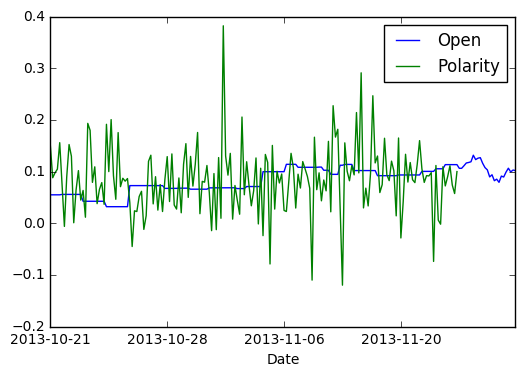

In [172]:
combined_frame['High'] = normalise(combined_frame['High'])
combined_frame['Open'] = normalise(combined_frame['Open'])
combined_frame[['Open', 'Polarity']].iloc[-1000:-800].plot()

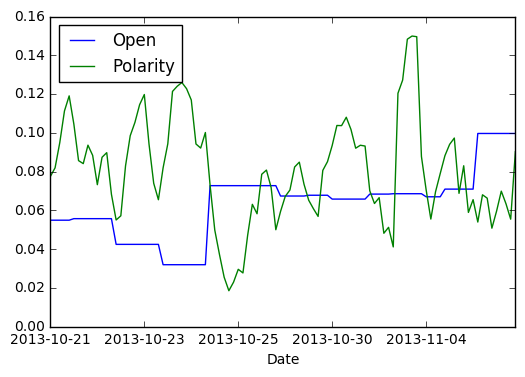

In [173]:
import pandas

combined_frame_rolling_mean = combined_frame.copy()
combined_frame_rolling_mean['Polarity'] = combined_frame_rolling_mean['Polarity'].rolling(center=False, window=5).mean()
combined_frame_rolling_mean[['Open', 'Polarity']].iloc[-1000:-900].plot()

In [174]:
combined_frame_rolling_mean['Open'].corr(combined_frame_rolling_mean['Polarity'])

-0.054818342351168066

In [175]:
from azureml import DataTypeIds

dataset = ws.datasets.add_from_dataframe(
    dataframe=combined_frame_rolling_mean,
    data_type_id=DataTypeIds.GenericCSV,
    name='Enquities combined with news.csv',
    description='Enquities combined with news'
)

In [214]:
combined_frame_count = combined_frame.copy()
combined_frame_count = combined_frame_count.groupby(level=0).mean()
combined_frame_count['Count'] = normalise(combined_frame.groupby(level=0)['Count'].sum())

In [215]:
combined_frame_count['Count'] = combined_frame_count['Count'].rolling(center=False, window=20).mean()

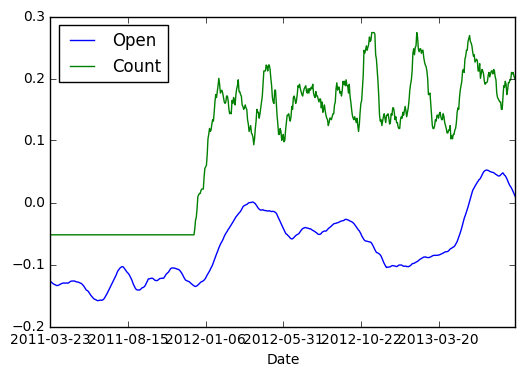

In [213]:
combined_frame_count[['Open', 'Count']].iloc[-1300:-900].plot()

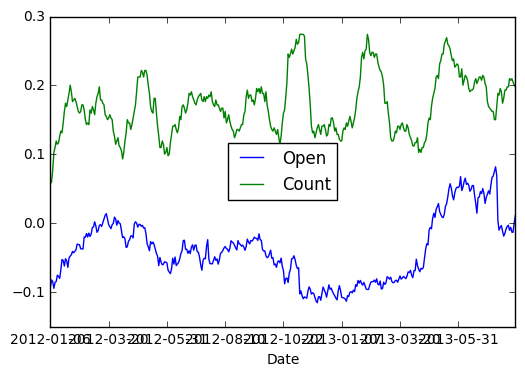

In [218]:
combined_frame_count[['Open', 'Count']].iloc[-1300:-900].plot()

In [221]:
combined_frame_count['Count'].iloc[-1300:-900].corr(combined_frame_count['Open'].iloc[-1300:-900])

0.26619961963140237

In [222]:
combined_frame_count['Count'].corr(combined_frame_count['Open'])

-0.20545943410070594

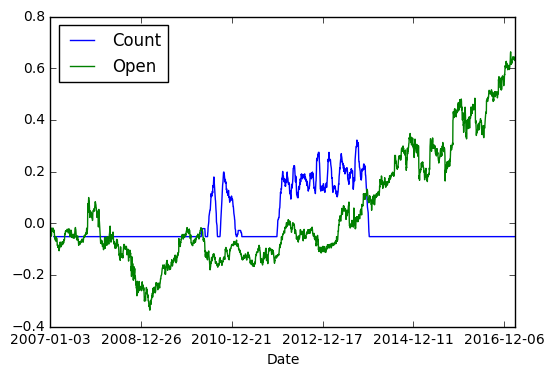

In [223]:
combined_frame_count[['Count', 'Open']].plot()

In [224]:
from azureml import DataTypeIds

dataset = ws.datasets.add_from_dataframe(
    dataframe=combined_frame_count.iloc[-1300:-900],
    data_type_id=DataTypeIds.GenericCSV,
    name='News count from 2007-01-03 to 2016-12-06.csv',
    description='News count from 2007-01-03 to 2016-12-06.csv'
)

In [227]:
combined_frame_count['Date'] = combined_frame_count.index.values

In [228]:
combined_frame_count

,Open,High,Count,Polarity,Date
Date,,,,,
2007-01-03,-0.045548,-0.044850,NaN,NaN,2007-01-03
2007-01-04,-0.049707,-0.050418,NaN,NaN,2007-01-04
2007-01-05,-0.051093,-0.054792,NaN,NaN,2007-01-05
2007-01-08,-0.050697,-0.047833,NaN,NaN,2007-01-08
2007-01-09,-0.043765,-0.046242,NaN,NaN,2007-01-09
2007-01-10,-0.047726,-0.052008,NaN,NaN,2007-01-10
2007-01-11,-0.048519,-0.034908,NaN,NaN,2007-01-11
2007-01-12,-0.030891,-0.022181,NaN,NaN,2007-01-12
2007-01-16,-0.018810,-0.020988,NaN,NaN,2007-01-16


In [229]:
from azureml import DataTypeIds

dataset = ws.datasets.add_from_dataframe(
    dataframe=combined_frame_count.iloc[-1300:-900],
    data_type_id=DataTypeIds.GenericCSV,
    name='News count with dates from 2007-01-03 to 2016-12-06.csv',
    description='News count with dates from 2007-01-03 to 2016-12-06.csv'
)